In [150]:
%load_ext jupyternotify
import numpy as np
import pandas as pd
import glob
import pickle
from scipy import signal
from matplotlib import pyplot as plt

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [2]:
# Pickling functions used to save and load the dictionary file

def save_obj(obj, name):
    with open('dataset/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('dataset/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
# Importing UN data
data=[]
name=[]
for file_name in glob.glob('dataset/UNDP_HDI/*.csv'):
    data.append(pd.read_csv(file_name,
                             skiprows=0,
                             na_values="..",
                             na_filter=True,
                             header=1))
    name.append(file_name.split('/')[-1].split('.')[0])

# This snippet is for dealing with the format of the imported dataframes
for i in range(len(data)):
    for col in data[i].columns:
        # Drop columns containing 'Unnamed'
        if "Unnamed" in col: data[i].drop(labels=col, axis=1, inplace=True) 

In [4]:
data_train = pd.read_csv('dataset/train.csv')
data_test = pd.read_csv('dataset/test.csv')
columns_train = list(data_train.columns)

In [133]:
# WARNING!------------------------------------------------------------------------
# This code snippet is not to be run if one wants to get a map
# of columns. In that case refer to the *pickled dictionary file* in the dataset
# folder. This is due to the manual corrections present later in this block, which
# are dependant on a certain sequence of columns from UN data, which in turn
# depends on the glob order. This load order might change on your run!

# This code is kept only to record my steps. 

import re

# Function str_comp compares how similar two strings are
# based on matching words or numbers.
# It returns a value from 0 to 1 (if duplicate words present could be more than 1).
# 0 means strings lstr1 and lstr2 contain completely different words
# and the larger the metric — the better similarity. 
# It's very crude, but gets the job done relatively well for my purpose. 

def str_comp(lstr1, lstr2): # lstr1 and lstr2 are strings to be compared
    
    # Forming 2 lists of words from strings, 
    # ignoring all non alphabet/number symbols.
    # filter removes unnecessary blank strings in the list
    # left by re.split.
    l1 = list(filter(None, re.split(r'\W',lstr1)))
    l2 = list(filter(None, re.split(r'\W',lstr2)))
    
    # matchings DO account for duplicate words in one or both lists of strings,
    # in which case it inflates the final metric to more than 1.
    # Ideally it should be fixed, but it works fine for comparing strings. 
    matchings = 0
    for s1 in l1:
        for s2 in l2:
            if s1.lower() == s2.lower(): matchings+=1
    return matchings/max([len(l1), len(l2)])


# Making a list containing indices to match columns between datasets
# based on the str_comp function 'metric'
col_map=[]
for i, col1 in enumerate(name):
    maxim = 0
    j_m = 0
    for j, col2 in enumerate(columns_train):
        comp = str_comp(col1,col2)
        # This part checks whether this combination of list of strings col1 and col2
        # are more similar than the previous best in this loop. It also checks
        # that the second list of strings col2 has not appeared before in
        # col_map to avoid duplicates. 
        if (comp >= maxim) and (j not in [x[1] for x in col_map]): 
            maxim = comp
            j_m = j
    col_map.append((i, j_m))

# Manually fixing mistakes made by the mapping script
# NOTE! This manual corrections may change on different loads of the data
#
# Please, use the columns dict pickle file in the dataset folder 
# for final mapping. 

corrections = {
    (37, 72): (37, 8),
    (43, 78): (43, 72),
    (56, 41): (56, 42),
    (57, 8): (57, 78),
    (10, 42): (10,41),
}

# Final list with corrections:
col_map_corr = [corrections.get(x,x) for x in col_map]

# Now it's nice and dandy
for i, j in col_map_corr:
    print(i, name[i])
    print(j, columns_train[j], '\n')

0 Education Index
9 Education Index 

1 Employment to population ratio (% ages 15 and older)
34 Employment to population ratio (% ages 15 and older) 

2 Population, ages 65 and older (millions)
20 Population, ages 65 and older (millions) 

3 Mortality rate, infant (per 1,000 live births)
17 Mortality rate, infant (per 1,000 live births) 

4 Human Development Index (HDI), female
70 Intergalactic Development Index (IDI), female 

5 Estimated gross national income per capita, female (2011 PPP$)
56 Estimated gross galactic income per capita, female 

6 Share of seats in parliament (% held by women)
47 Share of seats in senate (% held by female) 

7 Labour force participation rate (% ages 15 and older), male
33 Labour force participation rate (% ages 15 and older), male 

8 Remittances, inflows (% of GDP)
62 Remittances, inflows (% of GGP) 

9 International inbound tourists (thousands)
64 Intergalactic inbound tourists (thousands) 

10 Infants lacking immunization, measles (% of one-year-ol


This code was used to save the pickled dict.  
```python
col_map_abs = {}
for i, j in col_map_corr:
    col_map_abs[name[i].strip()] = columns_train[j].strip()

save_obj(col_map_abs, 'column_dict_from_UN_to_Contest_format')
```

In [5]:
col_map_abs=load_obj('column_dict_from_UN_to_Contest_format')

In [6]:
col_map_abs

{'Education Index': 'Education Index',
 'Employment to population ratio (% ages 15 and older)': 'Employment to population ratio (% ages 15 and older)',
 'Population, ages 65 and older (millions)': 'Population, ages 65 and older (millions)',
 'Mortality rate, infant (per 1,000 live births)': 'Mortality rate, infant (per 1,000 live births)',
 'Human Development Index (HDI), female': 'Intergalactic Development Index (IDI), female',
 'Estimated gross national income per capita, female (2011 PPP$)': 'Estimated gross galactic income per capita, female',
 'Share of seats in parliament (% held by women)': 'Share of seats in senate (% held by female)',
 'Labour force participation rate (% ages 15 and older), male': 'Labour force participation rate (% ages 15 and older), male',
 'Remittances, inflows (% of GDP)': 'Remittances, inflows (% of GGP)',
 'International inbound tourists (thousands)': 'Intergalactic inbound tourists (thousands)',
 'Infants lacking immunization, measles (% of one-year-ol

In [7]:
# Forming a complete list of all stripped entries in the Country column

full_list_dirty = set()
for i in range(len(data)):
    countries = [x for x in data[i].loc[:, 'Country'] if str(x) != 'nan']
    countries_stripped = set(map(lambda x: x.strip() , countries))
    full_list_dirty |= countries_stripped

In [128]:
entries_to_remove = set([
    'Arab States',
    'Developing Countries',
    'High human development',
    'Human Development',
    'Least Developed Countries',
    'Low human development',
    'Medium human development',
    'Organization for Economic Co-operation and Development',
    'Small Island Developing States',
    'South Asia',
    'Very high human development',
    'World',
    'East Asia and the Pacific',
    'Latin America and the Caribbean',
    'Regions',
    'Sub-Saharan Africa',
    'Europe and Central Asia',
    
])
full_list = full_list_dirty - entries_to_remove
full_list = sorted(list(full_list))

In [323]:
# Index rows of each dataframe in data by Country column
for i in range(len(data)):
    data[i].loc(:, 'Country')
    data[i].set_index('Country', inplace=True)

In [325]:
# Select only rows with countries and columns with years and the country list
for i,df in enumerate(data):
    data[i] = df.iloc[0:189, 1:]

In [583]:
for i in range(len(data)):
    for j, country in enumerate(data[i].loc[:, 'Country']):
        if str(country) != 'nan':
            data[i].loc[j, 'Country'] = country.strip()

In [571]:
# Creating a Multiindex. Turns out this particular way is unnecessary
undp_ind = pd.MultiIndex.from_product([cols, full_list], names=['year', 'country'])
undp_data = pd.DataFrame(None, index = undp_ind)

In [591]:
data[0][data[0]['Country'] == 'Afghanistan'].loc[:, '1990']

0    0.122
Name: 1990, dtype: object

In [608]:
np.data[0][data[0]['Country'] == 'a'].loc[:, '1990'].values[0]

numpy.ndarray

In [619]:
# How I collated ~80 tables of UNDP data into one compatible with
# the Contest dataset. Note it's VERY inefficient, due to the dataframe
# undp_data having to update for EVERY iteration. I'm sure there should
# exist a less obnoxious approach. However, I had to account for the inconsistency
# in the country names and even their existence in a given table. 

for df, nam in zip(data, name):
    for country in full_list:
        for year in df.columns[2:]:
            val = df[df['Country'] == country].loc[:, year].values
            if len(val) == 0: 
                undp_data.loc[(int(year), country), nam] = np.nan
            else: undp_data.loc[(int(year), country), nam] = val[0]

In [9]:
#Test data_trainset contains objects only of latest 10 years,
#including unmentioned in train data_train latest year 1016064
unique_years = data_train['galactic year'].unique()
print (unique_years)
print (unique_years.shape)

# print(np.sort(test['galactic year'].unique()))
# print(test['galactic year'].unique().shape)

unique_names = data_train['galaxy'].unique()
unique_names = np.sort(unique_names)
print (unique_names[:5])
print (unique_names.shape)

#Let's map all galactic years to years with increment of 1 year
# and map all galaxies to their unique integer key

#dictionary for replacement of galactic years with normal years
di = {val: ind+1990 for ind, val in enumerate(np.append(unique_years,
                                                     1016064))}
#dictionary for replacement of names with integer keys
di_names = {val: ind+1 for ind, val in enumerate(unique_names)}
data_train.replace({'galactic year':di}, inplace=True)
#test.replace({'galactic year':di}, inplace=True)

# data_train.replace({'galaxy':di_names}, inplace=True)
# test.replace({'galaxy':di_names}, inplace=True)

[ 990025  991020  992016  993012  994009  995006  996004  997002  998001
  999000 1000000 1001000 1002001 1003002 1004004 1005006 1006009 1007012
 1008016 1009020 1010025 1011030 1012036 1013042 1014049 1015056]
(26,)
['Andromeda Galaxy (M31)' 'Andromeda I' 'Andromeda II' 'Andromeda III'
 'Andromeda IX']
(181,)


In [10]:
unique_data_years = data_train['galactic year'].unique()
unique_galaxy_names = data_train['galaxy'].unique()

In [11]:
data_train_m = data_train.set_index(['galactic year', 'galaxy'])

In [12]:
# Preparing train set to compare with the UNDP dataset. I dropped some columns since I believe 
# the HDI Ranks for the year from which the original dataset was pulled might
# be different from the one in 2018
data_train_cl = data_train_m.drop(labels=['Intergalactic Development Index (IDI), Rank',
                          'Intergalactic Development Index (IDI), female, Rank',
                          'Intergalactic Development Index (IDI), male, Rank',
                          'y'
                         ],
                  axis = 1)

In [13]:
data_test = data_test.replace({'galactic year':di})
data_test = data_test.rename(columns={'galaxy':'country', 'galactic year': 'year'})
data_test_cl = data_test.set_index(['year', 'country']).drop(labels=['Intergalactic Development Index (IDI), Rank',
                          'Intergalactic Development Index (IDI), female, Rank',
                          'Intergalactic Development Index (IDI), male, Rank',
                         ],
                  axis = 1)


In [14]:
undp_test = undp_clean.loc[data_test_cl.rename(galaxy_to_country).index]
undp_test = undp_test.drop(labels='y', axis=1)

NameError: name 'undp_clean' is not defined

In [112]:
undp_test.to_csv('dataset/undp_test.csv', na_rep='nan')

In [37]:
# Inverse dictionary of col_map_abs: Contest column names -> UNDP column names
col_map_abs_inv = {v: k for k, v in col_map_abs.items()}

In [704]:
undp_order = [col_map_abs_inv.get(x) for x in data_train_cl.columns]

In [707]:
undp_clean = undp_data[undp_order]

In [134]:
undp_clean.drop(index=undp_clean.loc[idx[:, 'Europe and Central Asia'],].index)

Life expectancy Index  \
year country                                                     
1990 Afghanistan                                         0.467   
     Albania                                             0.797   
     Algeria                                             0.722   
     Andorra                                             0.870   
     Angola                                              0.389   
...                                                        ...   
2018 Venezuela (Bolivarian Republic of)                  0.802   
     Viet Nam                                            0.851   
     Yemen                                               0.709   
     Zambia                                              0.669   
     Zimbabwe                                            0.634   

                                         Life expectancy at birth  \
year country                                                        
1990 Afghanistan                                             50.3   
     Albania                                                 71.8   
     Algeria                                                 66.9   
     Andorra                                                 76.5   
     Angola                                                  45.3   
...                                                           ...   
2018 Venezuela (Bolivarian Republic of)                      72.1   
     Viet Nam                                                75.3   
     Yemen                                                   66.1   
     Zambia                                                  63.5   
     Zimbabwe                                                61.2   

                                         Gross national income (GNI) per capita (2011 PPP$)  \
year country                                                                                  
1990 Afghanistan                                                                    2193.0    
     Albania                                                                        4415.0    
     Algeria                                                                        9989.0    
     Andorra                                                                       49062.0    
     Angola                                                                         4139.0    
...                                                                                    ...    
2018 Venezuela (Bolivarian Republic of)                                             9070.0    
     Viet Nam                                                                       6220.0    
     Yemen                                                                          1433.0    
     Zambia                                                                         3582.0    
     Zimbabwe                                                                       2661.0    

                                         Income Index  \
year country                                            
1990 Afghanistan                                0.466   
     Albania                                    0.572   
     Algeria                                    0.695   
     Andorra                                    0.936   
     Angola                                     0.562   
...                                               ...   
2018 Venezuela (Bolivarian Republic of)         0.681   
     Viet Nam                                   0.624   
     Yemen                                      0.402   
     Zambia                                     0.541   
     Zimbabwe                                   0.496   

                                         Expected years of schooling (years)  \
year country                                                                   
1990 Afghanistan                                                         2.6   
     Albania                                                      

In [708]:
undp_clean.to_csv('dataset/undp_clean.csv', na_rep='nan')

In [145]:
# For loading 
undp_clean = pd.read_csv('dataset/undp_clean.csv', na_values='nan').set_index(['year', 'country'])
data_train_cl = pd.read_csv('dataset/data_train_cl.csv', na_values='nan').set_index(['galactic year', 'galaxy'])

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train_cl)
undp_clean_scaled = scaler.fit_transform(undp_clean)

data_train_scaled_sliced = scaler.fit_transform(data_train_cl.loc[(2015, slice(None)),])
undp_clean_scaled_sliced = scaler.fit_transform(undp_clean.loc[(2015, slice(None)),])

In [17]:
from sklearn.metrics.pairwise import pairwise_distances, nan_euclidean_distances

pair_dist = pairwise_distances(data_train_scaled,
                                undp_clean_scaled,
                                metric='nan_euclidean')
pair_dist_slice = pairwise_distances(data_train_scaled_sliced,
                               undp_clean_scaled_sliced,
                               metric='nan_euclidean')

In [18]:
pair_dist_m = np.nan_to_num(pair_dist, nan=np.inf)
pair_dist_slice_m = np.nan_to_num(pair_dist_slice, nan=np.inf)

In [19]:
np.argmin(pair_dist_m, axis = 1)

array([3886, 2671, 3886, ..., 5151,  483, 3911])

In [20]:
print(pair_dist_m.shape)
print(pair_dist_slice_m.shape)

(3865, 5684)
(87, 196)


In [43]:
a = np.argmin(pair_dist_slice_m, axis = 1)
print(a.shape)
a

(87,)


array([107,  36,  84, 109,   8,  34, 170,  86,  82,   2,  30,  73, 139,
       152, 146, 174, 125,  66, 137,  24,  76, 105,  12,  64, 189, 144,
        20, 168,  80,  47,  99,   0,  88,  57, 135,  62, 118, 184,  93,
        13,  22,  28,  90, 122,  69, 115, 149, 161, 154,  26, 181, 141,
        40, 179,  14,  45,  97, 131, 176, 127,  10,  18, 129,  16,  32,
        60, 112, 103,  95, 157, 164, 191,  35, 194, 166,  43,  71, 172,
         6, 120, 159,  38,  50,  52,  55, 133,  31])

In [21]:
# Compare averages for each galaxy across all years with the same for countries
data_train_aver = []
for galaxy in unique_names:
    data_train_aver.append(data_train_cl.loc[(slice(None), galaxy),].mean(axis = 0).values)

In [22]:
undp_clean_aver = []
for country in full_list:
    undp_clean_aver.append(undp_clean.loc[(slice(None), country),].mean(axis = 0).values)

In [26]:
#scaler.fit(data_train_aver + undp_clean_aver)

In [23]:
np.array(data_train_aver + undp_clean_aver).shape

(377, 74)

In [24]:
pair_dist_aver = pairwise_distances(scaler.fit_transform(data_train_aver),
                                    scaler.fit_transform(undp_clean_aver),
                                    metric='nan_euclidean')

In [25]:
pair_dist_aver.shape

(181, 196)

In [28]:
galaxy_to_country = np.argmin(pair_dist_aver, axis=1)
print(len(galaxy_to_country))
print(len(set(galaxy_to_country)))
print(galaxy_to_country)

181
175
[ 90  95  67  76  84  86  98 104  73 107 109  83  71 114  74  79 112 105
  99  96  72  13  96  41 120 117 111  38  62  22  14  17  51 180  55  44
  37  13   7 179  82  66  87  77  56  50  15  39 144  67  27   0 148 154
 167 131 174 188 193 130 189 192  59 191  43 138  40  20 171 126  42 185
  28  26  45   1  46  70 137 178 139 127  34 170 195 155 157 184 134 129
 122 143 140 133 124  88  19  69  57  52  46 125  60  47  97  81 159 158
 160 161  89  35 183  64 172 141 190 128 119 169 166 153 150 186 194  65
 182 132 106  92  53  93 186  79  16  85  29  49  80  94  63  10  33 113
   6  25  31   4  11 118 121  30  23 100   9 103  21   2  18 176 115 145
 142 164 175 136 146 177 173 181 149 168 135 152 163  36   8  24  32  12
 108]


In [27]:
np.argsort(pair_dist_aver[0])

array([ 90, 114, 152, 150, 182, 193,  59, 107, 123,  19,  91,  68,  28,
        48, 178,  73, 117,   5, 147, 111,   2,  22, 168, 181, 119, 190,
        94, 121,  79, 136,  80, 189,  95, 127, 115, 192, 194, 124, 122,
        13, 166, 140, 177,  74,  49,  72,   1,   7,  10,  66, 135,  64,
        47, 149,  50, 174, 172,  15,  97, 180,  87,  85,  11, 151,  29,
        89, 173,  18, 139, 179,  17, 144, 138, 148, 176,  37, 156,  88,
       130,   3,  20,  36, 154, 106,  81,  30, 191, 112,  62,  51, 104,
        38,  21,  52,  92, 171, 113, 137, 159,  96, 183, 184,  25, 163,
        44,  34,  76, 134,  55,  69,  98,  41,  26,   0,  57,  23, 118,
       155, 110, 146, 153, 120, 167,  56,  40, 100,  63, 133, 145, 132,
       102, 101, 141,  12,   4,  58,  39, 188, 116, 161,  70,  14, 160,
       105, 143, 142, 195, 129,  82,  83,   6,  24,  43, 175,  45,  31,
         9,  53, 128, 170,   8, 126,  67,  71,  16, 108,  27,  54,  99,
        86,  46, 165,  60, 185, 125,  65, 131, 169, 186,  77,  8

In [29]:
# Finding the best minimum, index of which is not yet in ind_galaxy_to_country
ind_galaxy_to_country = []
for i in range(pair_dist_aver.shape[0]):
    for ind in np.argsort(pair_dist_aver[i]):
        if ind not in ind_galaxy_to_country:
            ind_galaxy_to_country.append(ind)
            break
        else: continue

In [30]:
print(ind_galaxy_to_country)

[90, 95, 67, 76, 84, 86, 98, 104, 73, 107, 109, 83, 71, 114, 74, 79, 112, 105, 99, 96, 72, 13, 102, 41, 120, 117, 111, 38, 62, 22, 14, 17, 51, 180, 55, 44, 37, 133, 7, 179, 82, 66, 87, 77, 56, 50, 15, 39, 144, 142, 27, 0, 148, 154, 167, 131, 174, 188, 193, 130, 189, 192, 59, 191, 43, 138, 40, 20, 171, 126, 42, 185, 28, 26, 45, 1, 46, 70, 137, 178, 139, 127, 34, 170, 195, 155, 157, 184, 134, 129, 122, 143, 140, 81, 124, 88, 19, 69, 57, 52, 125, 16, 60, 47, 97, 2, 159, 158, 160, 161, 89, 35, 183, 64, 172, 141, 190, 128, 119, 169, 166, 153, 150, 186, 194, 65, 182, 132, 106, 92, 53, 93, 9, 48, 8, 85, 29, 49, 80, 94, 63, 10, 33, 113, 6, 25, 31, 4, 11, 118, 121, 30, 23, 100, 3, 103, 21, 68, 18, 176, 115, 145, 36, 164, 175, 136, 146, 177, 173, 181, 149, 168, 135, 152, 163, 147, 116, 24, 32, 12, 108]


In [31]:
galaxy_to_country = {unique_names[i]: full_list[val] for i, val in enumerate(ind_galaxy_to_country)}

In [32]:
galaxy_to_country

{'Andromeda Galaxy (M31)': 'Kiribati',
 'Andromeda I': "Lao People's Democratic Republic",
 'Andromeda II': 'Greece',
 'Andromeda III': 'Hungary',
 'Andromeda IX': 'Italy',
 'Andromeda V': 'Japan',
 'Andromeda VIII': 'Lesotho',
 'Andromeda X': 'Madagascar',
 'Andromeda XI': 'Haiti',
 'Andromeda XII': 'Maldives',
 'Andromeda XIX[60]': 'Malta',
 'Andromeda XV': 'Israel',
 'Andromeda XVII': 'Guinea-Bissau',
 'Andromeda XVIII[60]': 'Micronesia (Federated States of)',
 'Andromeda XX': 'Honduras',
 'Andromeda XXIII': 'Indonesia',
 'Andromeda XXII[57]': 'Mauritius',
 'Andromeda XXIV': 'Malawi',
 'Andromeda XXIX': 'Liberia',
 'Andromeda XXI[57]': 'Latvia',
 'Andromeda XXV': 'Guyana',
 'Andromeda XXVI': 'Bangladesh',
 'Andromeda XXVIII': 'Lithuania',
 'Antlia 2': 'Croatia',
 'Antlia B': 'Mozambique',
 'Antlia Dwarf': 'Mongolia',
 'Aquarius Dwarf Galaxy (DDO 210)': 'Mauritania',
 'Aquarius II': 'Congo',
 "Barnard's Galaxy (NGC 6822)": 'Gabon',
 'Boötes I': 'Botswana',
 'Boötes II': 'Barbados',
 

In [110]:
y_vals_train = data_train.set_index(['galactic year', 'galaxy'])['y'].rename(index=galaxy_to_country)
print(y_vals_train)

galactic year  galaxy                  
1990           Bhutan                      0.052590
               Turkey                      0.059868
               Central African Republic    0.050449
               South Sudan                 0.049394
               Luxembourg                  0.154247
                                             ...   
2015           Ecuador                     0.042324
               El Salvador                 0.036725
               Estonia                     0.166271
               Iraq                        0.024187
               Germany                     0.100069
Name: y, Length: 3865, dtype: float64


In [111]:
undp_clean['y']=y_vals_train

In [112]:
undp_train = undp_clean[~undp_clean['y'].isna()]

In [65]:
undp_train.to_csv('dataset/undp_train.csv', na_rep='nan')

In [ ]:
# a is a 

In [1128]:
np.min(pair_dist_aver, axis=1)

array([ 1.45108953,  2.61915455,  1.80124229,  1.85009302,  3.68582419,
        3.669292  ,  2.25003874,  3.51710718,  2.20323654,  1.32984736,
        1.84125435,  1.29592784,  2.49506282,  2.23924087,  1.31097102,
        2.62037736,  1.5142816 ,  1.56046141,  5.76352249,  3.16601322,
        1.60263693,  4.77030608,  1.46949284,  1.65363996,  1.81005207,
        2.38325953,  5.95957582,  1.4296124 ,  2.00692248,  1.35184105,
        1.30543542,  2.00697663,  1.72179088,  2.58951793,  1.88753206,
        1.42762494,  1.87330105,  2.19468185,  1.98739725,  1.3006709 ,
        2.26356551,  2.24771742,  1.70825767,  1.54722329,  1.46056319,
        2.44797543,  1.44637693,  2.40729054,  1.38793404,  3.19940706,
        2.51953744,  1.48672796,  1.8826662 ,  1.39966706,  2.27984215,
        1.41118212,  1.68547402,  1.64541788,  2.22169787,  2.51102204,
        1.52607197,  2.05287139,  1.61841482,  1.28392449,  2.89020874,
        1.57849058,  1.25922997,  1.45838409,  2.1405551 ,  1.51

In [75]:
print (unique_names[0])
print (full_list[90])

Andromeda Galaxy (M31)
Kiribati


In [34]:
data_train_cl.loc[(slice(None), 'NGC 5237'),]

,,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),...,Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII)
galactic year,galaxy,,,,,,,,,,,,,,,,,,,,,
1990,NGC 5237,1.055344,86.111354,59722.541463,1.034919,18.854220,15.265287,0.956134,1.102659,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29.397447,NaN,39.534366,NaN
1991,NGC 5237,0.972593,86.004846,56510.086480,1.010703,17.469359,14.327275,1.032387,0.994828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NGC 5237,1.010234,85.296479,53512.647065,1.011431,NaN,15.706228,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,NGC 5237,0.962562,89.861473,57278.164069,1.181806,18.112037,15.974448,1.134593,1.049597,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,NGC 5237,0.873332,80.544337,57819.940875,1.057590,18.963777,14.999847,1.039508,1.154907,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,NGC 5237,1.069215,89.822794,61593.357186,1.192004,18.518564,14.161656,0.978357,0.976743,NaN,NaN,...,NaN,NaN,NaN,1.112091,1.033894,1.069742,20.307295,NaN,27.442013,0.323446
1996,NGC 5237,0.999720,89.200836,46993.673866,1.092973,18.084112,13.945827,0.933711,0.986876,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,NGC 5237,1.063100,80.924815,53924.175436,1.070967,NaN,15.597634,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,NGC 5237,0.996754,87.396471,67464.756826,1.103541,18.852005,15.766237,1.094452,1.071042,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
undp_clean.loc[(slice(None), 'Germany'),]

,,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),...,Mobile phone subscriptions (per 100 people),"Internet users, total (% of population)",Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII)
year,country,,,,,,,,,,,,,,,,,,,,,
1990,Germany,0.854,75.5,31793.0,0.870,14.4,8.8,0.801,0.692,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,1.3,NaN
1991,Germany,0.857,75.7,32995.0,0.876,14.7,8.9,0.809,0.705,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,Germany,0.860,75.9,33325.0,0.877,14.8,9.1,0.814,0.715,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,Germany,0.864,76.1,32732.0,0.875,15.5,9.3,0.824,0.740,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,Germany,0.867,76.4,33196.0,0.877,15.6,9.5,0.829,0.750,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,Germany,0.871,76.6,33594.0,0.879,15.7,9.7,0.834,0.759,NaN,NaN,...,NaN,NaN,NaN,0.808,0.857,0.943,10.0,0.1,-0.3,0.156
1996,Germany,0.875,76.9,33807.0,0.880,15.8,9.8,0.839,0.767,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,Germany,0.879,77.2,34311.0,0.882,15.9,10.0,0.844,0.775,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,Germany,0.884,77.4,34853.0,0.884,16.1,10.4,0.853,0.794,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
undp_clean.drop(axis=0, index=[idx[2018, :],])

TypeError: '(2018, slice(None, None, None))' is an invalid key

In [121]:
undp_countries = np.array(undp_clean.index.levels[1])

In [122]:
train_countries = np.array(data_train.set_index(['galactic year', 'galaxy']).rename(index=galaxy_to_country).index.levels[1])

In [125]:
set(undp_countries)-set(train_countries)

{'Antigua and Barbuda',
 'Eritrea',
 'Europe and Central Asia',
 'France',
 'Hong Kong, China (SAR)',
 'India',
 "Korea (Democratic People's Rep. of)",
 'Liechtenstein',
 'Marshall Islands',
 'Nauru',
 'San Marino',
 'Seychelles',
 'Somalia',
 'Spain',
 'United States'}

In [105]:
idx = pd.IndexSlice

In [ ]:
scipy.stats.mode

In [146]:
undp_reduced = undp_clean.loc[idx[1990:2016, :],]

In [147]:
undp_reduced

Life expectancy Index  \
year country                                                     
1990 Afghanistan                                         0.467   
     Albania                                             0.797   
     Algeria                                             0.722   
     Andorra                                             0.870   
     Angola                                              0.389   
...                                                        ...   
2016 Venezuela (Bolivarian Republic of)                  0.806   
     Viet Nam                                            0.849   
     Yemen                                               0.709   
     Zambia                                              0.653   
     Zimbabwe                                            0.620   

                                         Life expectancy at birth  \
year country                                                        
1990 Afghanistan                                             50.3   
     Albania                                                 71.8   
     Algeria                                                 66.9   
     Andorra                                                 76.5   
     Angola                                                  45.3   
...                                                           ...   
2016 Venezuela (Bolivarian Republic of)                      72.4   
     Viet Nam                                                75.2   
     Yemen                                                   66.1   
     Zambia                                                  62.5   
     Zimbabwe                                                60.3   

                                         Gross national income (GNI) per capita (2011 PPP$)  \
year country                                                                                  
1990 Afghanistan                                                                    2193.0    
     Albania                                                                        4415.0    
     Algeria                                                                        9989.0    
     Andorra                                                                       49062.0    
     Angola                                                                         4139.0    
...                                                                                    ...    
2016 Venezuela (Bolivarian Republic of)                                            12570.0    
     Viet Nam                                                                       5638.0    
     Yemen                                                                          1966.0    
     Zambia                                                                         3622.0    
     Zimbabwe                                                                       2246.0    

                                         Income Index  \
year country                                            
1990 Afghanistan                                0.466   
     Albania                                    0.572   
     Algeria                                    0.695   
     Andorra                                    0.936   
     Angola                                     0.562   
...                                               ...   
2016 Venezuela (Bolivarian Republic of)         0.730   
     Viet Nam                                   0.609   
     Yemen                                      0.450   
     Zambia                                     0.542   
     Zimbabwe                                   0.470   

                                         Expected years of schooling (years)  \
year country                                                                   
1990 Afghanistan                                                         2.6   
     Albania                                                      

8.396999999999984

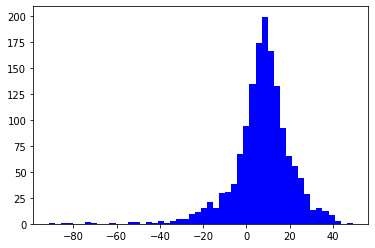

In [178]:
hist1 = plt.hist(undp_reduced.iloc[:, -4], color='b', label='UNDP', bins=50)
peak1 = (hist1[1][np.argmax(hist1[0])] 
 + hist1[1][np.argmax(hist1[0])+1])/2

In [207]:
list(enumerate(undp_reduced.columns))

[(0, 'Life expectancy Index'),
 (1, 'Life expectancy at birth'),
 (2, 'Gross national income (GNI) per capita (2011 PPP$)'),
 (3, 'Income Index'),
 (4, 'Expected years of schooling (years)'),
 (5, 'Mean years of schooling (years)'),
 (6, 'Human Development Index (HDI)'),
 (7, 'Education Index'),
 (8, 'Population using at least basic drinking-water services (%)'),
 (9, 'Population using at least basic sanitation services (%)'),
 (10, 'Gross capital formation (% of GDP)'),
 (11, 'Population, total (millions)'),
 (12, 'Population, urban (%)'),
 (13, 'Mortality rate, under-five (per 1,000 live births)'),
 (14, 'Mortality rate, infant (per 1,000 live births)'),
 (15,
  'Old age dependency ratio (old age (65 and older) per 100 people (ages 15-64))'),
 (16, 'Population ages 15–64 (millions)'),
 (17, 'Population, ages 65 and older (millions)'),
 (18, 'Life expectancy at birth, male (years)'),
 (19, 'Life expectancy at birth, female (years)'),
 (20, 'Population, under age 5 (millions)'),
 (21, 

In [303]:
np.nanpercentile(undp_reduced.iloc[:, i], 100)

1414.0

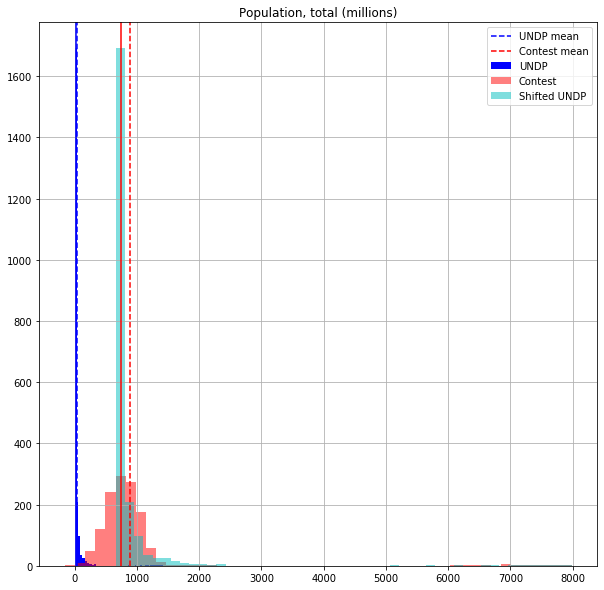

k = 5.183979909474677
c = 663.1759101840099
blue std = 132.3153936017793
blue mean = 34.44666666666668
blue median = 7.2
blue min = 0.0
blue max = 1414.0 

red std = 893.7946355272816
red mean = 891.288630912939
red median = 774.1061244886386
red min = -160.43617880443858
red max = 7993.3235021812025


In [307]:
i = 11
plt.figure(figsize=(10,10))
hist1 = plt.hist(undp_reduced.iloc[:, i], color='b', label='UNDP', bins=50)
hist2 = plt.hist(data_train_cl.iloc[:, i], color='r', alpha=0.5, label='Contest', bins=50)

peak1 = (hist1[1][np.argmax(hist1[0])]
         + hist1[1][np.argmax(hist1[0])+1])/2
peak2 = (hist2[1][np.argmax(hist2[0])]
         + hist2[1][np.argmax(hist2[0])+1])/2

max1 = np.nanpercentile(undp_reduced.iloc[:, i], 100)
max2 = np.nanpercentile(data_train_cl.iloc[:, i].max(), 100)

k = (peak2 - max2) / (peak1 - max1)
c = peak2 - peak1*k

plt.axvline(x=peak1, color='b', ls='-')
plt.axvline(x=peak2, color='r', ls='-')

plt.hist(k*undp_reduced.iloc[:, i] + c, alpha=0.5, color='c', label='Shifted UNDP', bins=50)
plt.axvline(x=undp_reduced.iloc[:, i].mean(), color='b', ls='--', label='UNDP mean')
plt.axvline(x=data_train_cl.iloc[:, i].mean(), color='r', ls='--', label='Contest mean')
#plt.axvline(x=(undp_reduced.iloc[:, i] + 0.2*undp_reduced.iloc[:, i].median()).median(), color='y', ls='--')

plt.grid()
plt.title(undp_reduced.columns[i])
plt.legend()
plt.show()
print('k =', k)
print('c =', c)

print('blue std =', np.std(undp_reduced.iloc[:, i]))
print('blue mean =', undp_reduced.iloc[:, i].mean())
print('blue median =', undp_reduced.iloc[:, i].median())
print('blue min =', undp_reduced.iloc[:, i].min())
print('blue max =', undp_reduced.iloc[:, i].max(), '\n')

print('red std =', np.std(data_train_cl.iloc[:, i]))
print('red mean =', data_train_cl.iloc[:, i].mean())
print('red median =', data_train_cl.iloc[:, i].median())
print('red min =', data_train_cl.iloc[:, i].min())
print('red max =', data_train_cl.iloc[:, i].max())



In [1133]:
undp_clean.describe()

,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),...,Mobile phone subscriptions (per 100 people),"Internet users, total (% of population)",Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII)
count,5568.000000,5568.000000,5530.000000,5530.000000,5360.000000,5043.000000,4993.000000,4993.000000,3431.000000,3421.000000,...,2093.000000,1947.000000,1688.000000,1915.000000,1914.000000,1913.000000,1632.000000,1644.000000,1822.000000,1792.000000
mean,0.740764,68.148563,15186.824051,0.656812,11.785261,7.472655,0.656677,0.580204,84.176333,71.058170,...,87.943144,38.664201,6.404858,0.663700,0.708495,0.925704,7.227145,1.925304,-4.415587,0.384397
std,0.148879,9.678238,18543.348811,0.182654,3.331989,3.172187,0.165553,0.187169,18.884707,30.351158,...,47.301448,30.322201,2.906059,0.175679,0.150530,0.087908,14.057992,4.355476,25.172391,0.193390
min,0.095000,26.200000,261.000000,0.145000,2.100000,0.300000,0.189000,0.081000,19.000000,3.000000,...,0.000000,0.000000,1.200000,0.081000,0.252000,0.204000,-99.000000,0.100000,-762.000000,0.037000
25%,0.647000,62.075000,2933.750000,0.510250,9.900000,4.800000,0.530000,0.439000,75.000000,46.000000,...,54.000000,9.800000,4.400000,0.531000,0.594000,0.886000,1.800000,0.100000,-5.600000,0.209750
50%,0.778000,70.550000,8123.500000,0.664000,12.100000,7.800000,0.681000,0.608000,93.000000,85.000000,...,95.900000,34.900000,5.900000,0.693000,0.728000,0.955000,8.300000,0.400000,-2.500000,0.398500
75%,0.850000,75.300000,19925.000000,0.800000,14.000000,10.100000,0.787000,0.715000,99.000000,98.000000,...,121.000000,65.150000,8.100000,0.807500,0.822000,0.983000,14.400000,1.500000,-0.200000,0.545000
max,0.995000,84.700000,114214.000000,1.000000,23.300000,14.100000,0.954000,0.946000,100.000000,100.000000,...,259.400000,100.000000,26.300000,0.946000,0.960000,1.052000,49.200000,28.400000,77.100000,0.841000


In [1131]:
undp_clean.loc[(slice(None), 'Kiribati'),]

,,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),...,Mobile phone subscriptions (per 100 people),"Internet users, total (% of population)",Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII)
year,country,,,,,,,,,,,,,,,,,,,,,
1990,Kiribati,0.610,59.6,2358.0,0.477,10.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.2,NaN
1991,Kiribati,0.616,60.1,3058.0,0.517,10.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,Kiribati,0.622,60.5,3075.0,0.518,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,Kiribati,0.628,60.8,2930.0,0.510,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,Kiribati,0.634,61.2,2922.0,0.510,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,Kiribati,0.639,61.5,3041.0,0.516,10.9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,Kiribati,0.644,61.9,2620.0,0.493,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,Kiribati,0.649,62.2,3114.0,0.519,10.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,Kiribati,0.654,62.5,3448.0,0.535,10.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
